This is a jupyter notebook companion to *Data Functionalization and Gas Chromatography in Python* from the Journal of Chemical Education. This notebook is designed to be run in [binder](https://mybinder.org/) and thus without need for any installation. This notebook uses symmetric gaussian functions for simplicity.

first thing we need to do is import all of the modules we need. We can think of modules as a sort of 'toolbox'
containing various prebuilt tools which we can call into use in our python scripts.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.integrate import quad

Gas Chromatography is a useful technique in analytical chemistry, as there is a direct relationship between the observed GC signal and the quantity of material in our sample. Furthermore, there is a direct relationship between the *ratios* of material GC signals and their molar ratios, which is what we're looking for when constructing say, an binary phase diagram. And when it comes to modeling Gas Chromatography, the key is to recognize that, since the the relative transfer from 
the stationary phase to the mobile phase for any individual molecule within the GC column is random, we can model 
the GC signal as a normal gaussian distribution. Let's define a python function that is a gaussian distribution here, which is of the form:

\begin{align*}
\large gaussian(x,a,b,c) = \Large a\cdot e^{\huge \frac{-(x-b)^2}{c^2}}
\end{align*}

or, in python...

In [39]:
def gaussian(x,a,b,c):
    return a*np.exp((-(x-b)**2.0)/c**2.0)

To get a sense of what gaussian distributions looks like, lets plot a few:

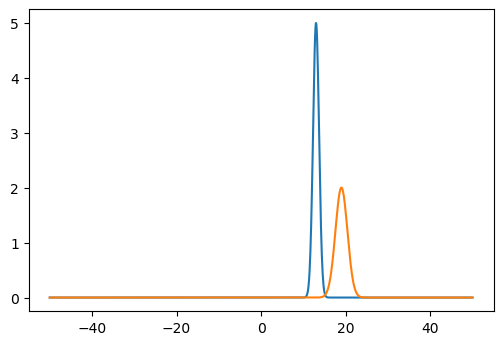

In [72]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(x, gaussian(x,5,13,1))
ax.plot(x, gaussian(x,2,19,2))

plt.show()


As we can see by comparing our two functions, the parameters a, b, and c determine how the gaussian distribution manifests as a function of x. The parameter `a` controls the amplitude, `b` controls the position, and `c` controls the spread.

So now lets look at some GC data, and see how we might be able to use these gaussian functions in some useful manner - We're going to import some data available through GitHub for this example.

In [73]:
data1to1 = pd.read_csv('https://raw.githubusercontent.com/1mikegrn/pyGC/master/tests/Sample%20GC%20data%201%20pt%20acetone%201%20pt%20cyclohexane.csv').to_numpy()
data2to1 = pd.read_csv('https://raw.githubusercontent.com/1mikegrn/pyGC/master/tests/Sample%20GC%20data%202%20pt%20acetone%201%20pt%20cyclohexane.csv').to_numpy()

Let's plot one of these examples:

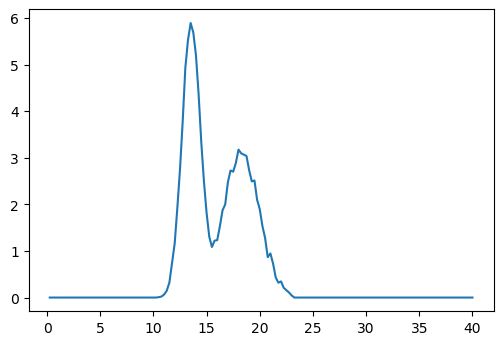

In [74]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(data1to1[:,0], data1to1[:,1])
plt.show()


As we can see, it's a little noisy, but our data plot actually looks pretty similar to our model GC functions. Let's go ahead and superimpose them on the same graph and see what we get:

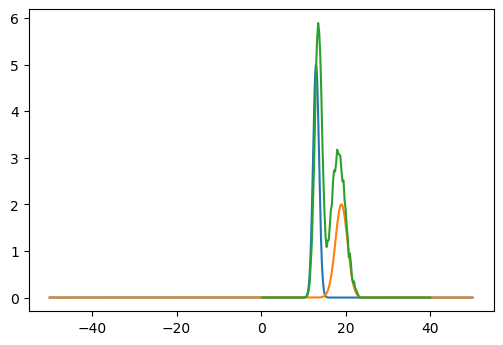

In [75]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(x, gaussian(x,5,13,1))
ax.plot(x, gaussian(x,2,19,2))
ax.plot(data1to1[:,0], data1to1[:,1])

plt.show()

Okay, they were close...ish. Not enough to where we can use the gaussians to calculate the area we're looking for. What we need to do is find some way to "fit" our functions to the data. Or in other words, minimize the difference between our data and our gaussians.

It turns out there is an algorithm which does exactly this - the Levenberg–Marquardt Algorithm (LMA). What this algorithm does is look at every point on the data and compares it to the point of a model function as a distance, called the *residual*. It uses these two points to determine a *gradient*, essentially a direction the function needs to move to minimize the residual, and steps the function that direction accordingly until the minimization condition is satisfied.

In order to use the LMA, we need to take one extra step and define a total function that LMA can work with. Essentially, this function is a *superposition* of gaussian functions, and can be defined as so:

\begin{align*}
\large GaussSum(x, p) = \sum_{p=1}^{k} \Large a_i\cdot e^{\huge \frac{-(x-b_i)^2}{c_i^2}}
\end{align*}

or, in python...

In [76]:
def GaussSum(x, p):
    return sum(gaussian(x, p[3*k], p[3*k+1], p[3*k+2]) for k in range(n))

this function states that for some point p in a set such that p = [a, b, c] as previously defined, a function GaussSum can be defined as an arbitrary sum of 'n' gaussians.

Finally, we need to define the residual:

In [77]:
def residuals(p, y, x):
    return y - GaussSum(x,p)

now that we have our functions defined, lets go ahead and define some initial guess values for python to work with. let's go ahead and use the one's that we tried prevousily, as they were in the 'ballpark' of the optimal solution so to say.

In [78]:
initials = [5, 13, 1], [2, 19, 2]

as we can see, we're defining two initial functions, so we can tell python that `n` is equal to two

In [79]:
n=2

finally, we can implement what's called 'least squares regression', which is a scipy module which we imported earlier that implements LMA.

We can call the leastsq docstrings to get a sense of what this function is expecting:

In [80]:
leastsq?

As we can see, it's expecting at least a function, a set of initial parameters, and data arguments. We have all of those defined, so let's pass them through the function:

In [81]:
cnst = leastsq(residuals, initials, args=(data1to1[:,1],data1to1[:,0]))

In [82]:
print(cnst)

(array([ 5.8523617 , 13.5370064 ,  1.20593774,  3.11756896, 18.27210729,
        2.36232469]), 1)


the least squares function returned to us a tuple of two values; one, the list of refined constants, and two, an integer value which tells us that the algorithm is happy and found a solution. For our purposes, we only need the list.

Lets go ahead and take the returned list and pass that through our GaussSum function as the `p` variables, and let's graph that against the raw data:

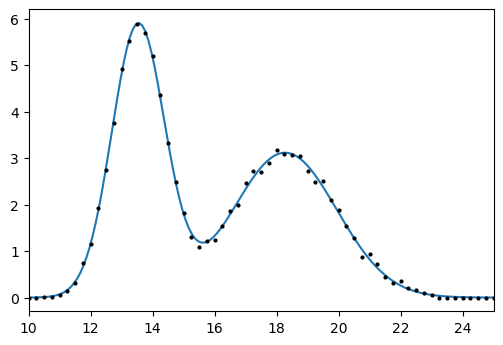

In [91]:
fig, ax = plt.subplots(dpi = 100)

ax.plot(x, GaussSum(x,cnst[0]))

# let's also format the plot a bit to make it easier to see
ax.plot(data1to1[:,0], data1to1[:,1], 'ko', markersize = 2)
ax.set_xlim(10,25)

plt.show()

Looks pretty good! but we were interested in the individual gaussian curves, not the sum. Lets instead plot our data against two gaussian functions, where every 3 points in our `cnst` list are the [a, b, c] parameters from our initial guesses:

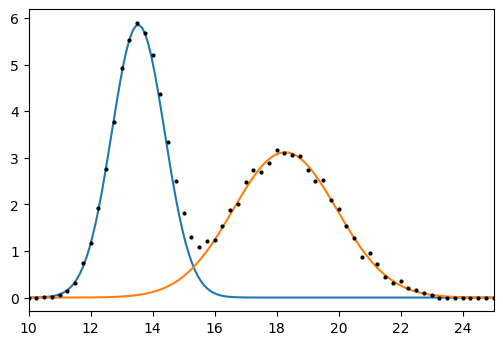

In [96]:
fig, ax = plt.subplots(dpi = 100)

for i in range(n):
    ax.plot(x, gaussian(x,cnst[0][3*i], cnst[0][3*i+1], cnst[0][3*i+2]))

# let's also format the plot a bit to make it easier to see
ax.plot(data1to1[:,0], data1to1[:,1], 'ko', markersize = 2)
ax.set_xlim(10,25)

plt.show()

Awesome! We've deconvoluted our data peaks. With our gaussian functions now defined, we can integrate them, and use the integral values to determine the molar ratio. To do this, we're going to use another tool from scipy called quad(), which is a tool from numerical methods that integrates functions:

In [101]:
areas = [quad(gaussian,data1to1[0,0],data1to1[data1to1.shape[0]-1,0],
        args=(cnst[0][3*i], cnst[0][3*i+1], cnst[0][3*i+2]))[0] 
        for i in range(n)]

print(areas)

[12.5092416916701, 13.053608845461651]


These two values correspond to the numerically-resolved integral areas of the two distribution functions. 

One of the great things about using computers for this type of work is that scaling is trivial - we have the method for determining the integral areas codified, now, in order to determine the next set, we only need to feed our program a new data set! Teh computer handles the rest.

Let's see what I mean when we put it all togehter with the data2to1 set we also imported. (I'm also going to add some formatting stuff to make out graph all-inclusive)

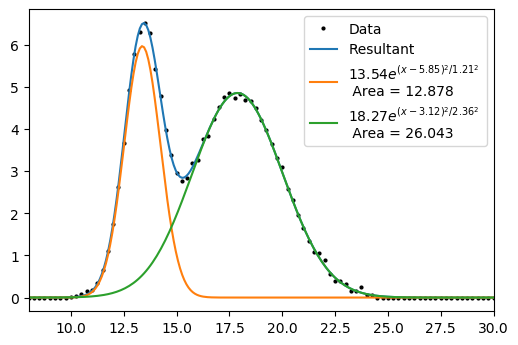

In [115]:
cnsts2to1 = leastsq(residuals, initials, args=(data2to1[:,1],data2to1[:,0]))

fig, ax = plt.subplots(dpi = 100)

ax.plot(data2to1[:,0], data2to1[:,1], 'ko', markersize = 2)
ax.plot(x, GaussSum(x,cnsts2to1[0]))
ax.set_xlim(8,30)

for i in range(n):
    ax.plot(x, gaussian(x,cnsts2to1[0][3*i], cnsts2to1[0][3*i+1], cnsts2to1[0][3*i+2]))

areas = [quad(gaussian,data2to1[0,0],data1to1[data2to1.shape[0]-1,0],
        args=(cnsts2to1[0][3*i], cnsts2to1[0][3*i+1], cnsts2to1[0][3*i+2]))[0] 
        for i in range(n)]

# creates a list of titles for each data set.
ledger = ['Data', 'Resultant']
for i in range(n):
    ledger.append(str(round(cnst[0][3*i+1], 2)) + '$e^{(x-' + str(round(cnst[0][3*i], 2)) + ')^2 / ' + str(round(cnst[0][3*i + 2], 2)) + '^2}$' + ' \n Area = ' + str(round(areas[i], 3))) 

#adds the ledger to the graph.
ax.legend(ledger)

plt.show()

Simple! All that really changed was our initial guess values, the input data, and a bit of formatting - the computer handled the rest.

To make analysis simple, everything demonstrated herein has been written into two python files - "Symmetric GC integration.py" and "Asymmetric GC integration.py". When running these files, it's not necessary to adjust the formatting - all they require is changing the input data and the initial function guesses. But, feel free to play around with those files and see what you can do to try working with other types of data or other functions. The possibilities are limitless! 